# Image Geometrical Transformations

We will see how to apply geometric transformations to an image. But first, let's study a simpler case where geometric transformations are applied to a set of points.

## 1. Transformation of a set of points

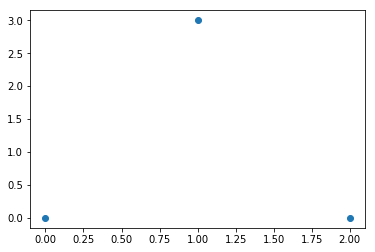

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos,sin

# Array containing three poins. Each point is a column of the array.
points = np.array([[0., 2., 1.],
                   [0., 0., 3.],
                   [1., 1., 1.]])

plt.plot(points[0], points[1], 'o')

### 1.1 Translation

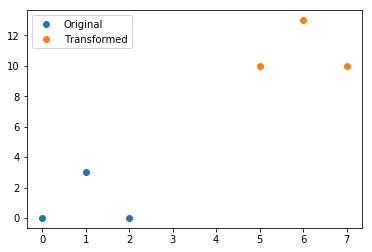

In [2]:
def get_translation_matrix(tx, ty):
    Tt = np.array([[1., 0., tx],
                   [0., 1., ty],
                   [0., 0., 1.]])
    return Tt

tx = 5
ty = 10
Tt = get_translation_matrix(tx, ty)
# Applying the transformation
points_t = np.dot(Tt, points)

plt.plot(points[0], points[1], 'o')
plt.plot(points_t[0], points_t[1], 'o')
plt.legend(('Original', 'Transformed'))

### 1.2 Rotation

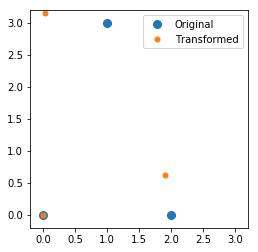

In [3]:
def get_rotation_matrix(angle):
    Tr = np.array([[cos(angle), -sin(angle), 0.],
                   [sin(angle),  cos(angle), 0.],
                   [         0.,         0., 1.]])
    return Tr

angle = np.pi/10.
Tr = get_rotation_matrix(angle)
points_r = np.dot(Tr, points)

plt.subplot(111, aspect='equal')
plt.plot(points[0], points[1], 'o', ms=8)
plt.plot(points_r[0], points_r[1], 'o', ms=5)
plt.xlim((-0.2, 3.2))
plt.ylim((-0.2, 3.2))
plt.legend(('Original', 'Transformed'))

### 1.3 Affine transformation

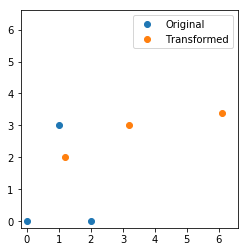

In [4]:
def get_affine_matrix():
    Ta = np.array([[1.0, 1.3, 1.2],
                   [0.5, 0.3, 2.0],
                   [ 0.,  0., 1.]])
    return Ta

Ta = get_affine_matrix()
points_a = np.dot(Ta, points)

plt.subplot(111, aspect='equal')
plt.plot(points[0], points[1], 'o')
plt.plot(points_a[0], points_a[1], 'o')
plt.xlim((-0.2, 6.6))
_ = plt.ylim((-0.2, 6.6))
plt.legend(('Original', 'Transformed'))

# 2. Image geometric transformations

In [5]:
def get_similarity_transform_matrix(tx, ty, angle, s):
    '''Return a matrix describing the similarity transformation having translation
       (tx, ty), rotation given by angle and scaling given by s.'''
    
    Tr = np.array([[s*cos(angle), -s*sin(angle), tx],
                   [s*sin(angle),  s*cos(angle), ty],
                   [          0.,            0., 1.]])
    return Tr

def apply_similarity_transform(point, T, reference_point):
    '''Apply similarity transformaiton to a point represented by the variable 
       'point'. 'T' is the transformaiton matrix and 'reference_poin't sets the anchor
       point for the rotation and scaling.'''

    point = np.array(point)
    reference_point = np.array(reference_point)
    point -= reference_point
    point_homogeneous = np.ones((3,1))
    point_homogeneous[0] = point[0]
    point_homogeneous[1] = point[1]
    
    point_transf = np.dot(T, point_homogeneous)
    point_transf = point_transf[:2, 0]
    point_transf += reference_point
    
    return point_transf

def apply_similarity_transform_arr(points, T, reference_point):
    '''Apply similarity transformaiton to a list of points represented by the 
       variable point. T is the transformaiton matrix and reference_point sets 
       the anchor point for the rotation and scaling.'''    
    
    points = np.array(points)
    reference_point = np.array(reference_point)
    num_points = points.shape[0]
    points -= reference_point
    points = points.T
    points_homogeneous = np.ones((3, num_points))
    points_homogeneous[:2] = points
    
    points_transf = np.dot(T, points_homogeneous)
    points_transf = points_transf[:2].T
    points_transf += reference_point
    
    return points_transf

def transform_image(img, M, reference_point, out_img_corners):
    '''Transforms an image using transformaiton matrix M. 'reference_point' 
       sets the anchor point for the rotation and scaling and 'out_img_corners'
       sets the bounds for the output image.'''
    
    out_img_upper_left = out_img_corners[0]
    out_img_bottom_right = out_img_corners[1]
    
    img_width = out_img_bottom_right[0] - out_img_upper_left[0]
    img_height = out_img_bottom_right[1] - out_img_upper_left[1]
    M_inv = np.linalg.inv(M)

    out_img = np.zeros((img_height, img_width))
    for row in range(img_height):
        new_y_coord = row + out_img_upper_left[1]
        for col in range(img_width):
            new_x_coord = col + out_img_upper_left[0]
            orig_x_coord, orig_y_coord = apply_similarity_transform((new_x_coord, new_y_coord), M_inv, reference_point)

            if orig_x_coord>=0 and orig_x_coord<img.shape[1]-1 and orig_y_coord>=0 and orig_y_coord<img.shape[0]-1:
                orig_x_coord = int(round(orig_x_coord))
                orig_y_coord = int(round(orig_y_coord))
                out_img[row, col] = img[orig_y_coord, orig_x_coord]
                
    return out_img

def transform_image_interpol(img, M, reference_point, out_img_corners):
    '''Transforms an image using transformaiton matrix M. If the coordinates in the 
       original image do not fall exactly at a pixel position, the intensity is 
       inteprolated. 'reference_point' sets the anchor point for the rotation and 
       scaling and 'out_img_corners' sets the bounds for the output image.'''
    
    out_img_upper_left = out_img_corners[0]
    out_img_bottom_right = out_img_corners[1]
    
    img_width = out_img_bottom_right[0] - out_img_upper_left[0]
    img_height = out_img_bottom_right[1] - out_img_upper_left[1]
    M_inv = np.linalg.inv(M)

    out_img = np.zeros((img_height, img_width))
    for row in range(img_height):
        y_coord = row + out_img_upper_left[1]
        for col in range(img_width):
            x_coord = col + out_img_upper_left[0]
            orig_x_coord, orig_y_coord = apply_similarity_transform((x_coord, y_coord), M_inv, reference_point)

            if orig_x_coord>=0 and orig_x_coord<img.shape[1]-2 and orig_y_coord>=0 and orig_y_coord<img.shape[0]-2:
                val = bilinear_interpol(img, (orig_x_coord, orig_y_coord))
                out_img[row, col] = val
                
    return out_img

def bilinear_interpol(img, point):
    '''Return the intensity at the position indicated by 'point'. The position can be
       any floating point value inside the range [0, img.shape[0]-2] for the row and
       [0, img.shape[1]-2] for the column.'''
       
    x_int = int(point[0])
    y_int = int(point[1])
    x_frac = point[0]-x_int
    y_frac = point[1]-y_int
    a00 = img[y_int, x_int]
    a10 = img[y_int, x_int+1]
    a01 = img[y_int+1, x_int]
    a11 = img[y_int+1, x_int+1]
    val = a00*(1-x_frac)*(1-y_frac) + a10*x_frac*(1-y_frac) + a01*(1-x_frac)*y_frac + a11*x_frac*y_frac
    return val
    

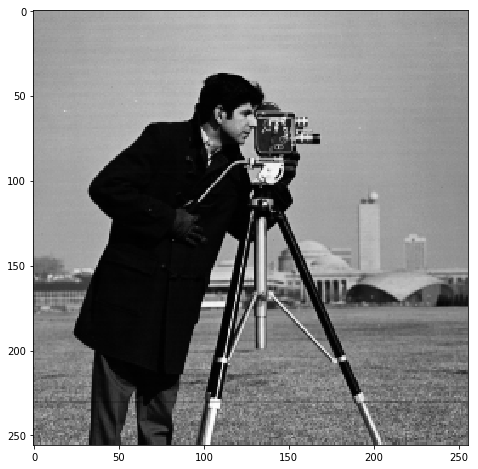

In [6]:
img = plt.imread('cameraman.tiff')
plt.figure(figsize=[8,8])
plt.imshow(img, 'gray')

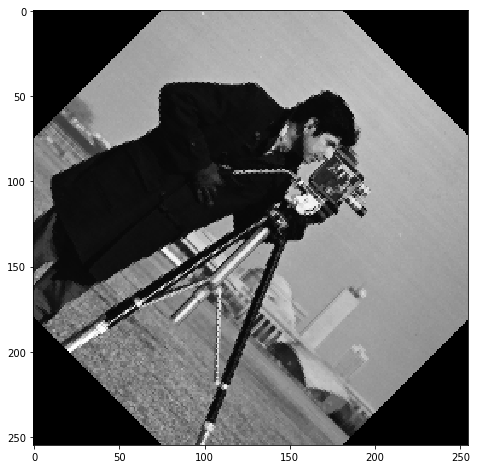

In [7]:
# Define where to crop the output image
out_img_upper_left = (0, 0)
out_img_bottom_right = (255, 255)

Ts = get_similarity_transform_matrix(0, 0, np.pi/4, 1)
reference_point = (img.shape[1]//2, img.shape[0]//2)

out_img_corners = [out_img_upper_left, out_img_bottom_right]
out_img = transform_image(img, Ts, reference_point, out_img_corners)

plt.figure(figsize=[8,8])
plt.imshow(out_img, 'gray')

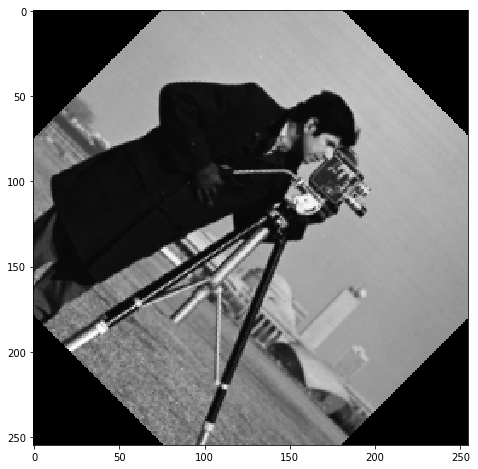

In [8]:
# Transform image using linear interpolation
out_img = transform_image_interpol(img, Ts, reference_point, out_img_corners)

plt.figure(figsize=[8,8])
plt.imshow(out_img, 'gray')